<a href="https://colab.research.google.com/github/AabidMK/RealtyAI_Infosys_Internship_Aug2025/blob/Kalluri_Gayathri/Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
#Load dataset
df = pd.read_csv("Real Estate Data V21.csv")

In [3]:
#Provides No.of rows and Cols
df.shape
#In the output there are 14528 Rows and 9 Coumns

(14528, 9)

In [4]:
# View first 5 rows
df.head()

,Name,Property Title,Price,Location,Total_Area,Price_per_SQFT,Description,Baths,Balcony
0,Casagrand ECR 14,"4 BHK Flat for sale in Kanathur Reddikuppam, C...",₹1.99 Cr,"Kanathur Reddikuppam, Chennai",2583,7700.0,Best 4 BHK Apartment for modern-day lifestyle ...,4,Yes
1,"Ramanathan Nagar, Pozhichalur,Chennai",10 BHK Independent House for sale in Pozhichal...,₹2.25 Cr,"Ramanathan Nagar, Pozhichalur,Chennai",7000,3210.0,Looking for a 10 BHK Independent House for sal...,6,Yes
2,DAC Prapthi,"3 BHK Flat for sale in West Tambaram, Chennai",₹1.0 Cr,"Kasthuribai Nagar, West Tambaram,Chennai",1320,7580.0,"Property for sale in Tambaram, Chennai. This 3...",3,No
3,"Naveenilaya,Chepauk, Triplicane,Chennai",7 BHK Independent House for sale in Triplicane...,₹3.33 Cr,"Naveenilaya,Chepauk, Triplicane,Chennai",4250,7840.0,Entire Building for sale with 7 units of singl...,5,Yes
4,VGN Spring Field Phase 1,"2 BHK Flat for sale in Avadi, Chennai",₹48.0 L,"Avadi, Chennai",960,5000.0,"Property for sale in Avadi, Chennai. This 2 BH...",3,Yes


In [5]:
#Name of Attributes/Colums present in the dataset
df.columns

Index(['Name', 'Property Title', 'Price', 'Location', 'Total_Area',
       'Price_per_SQFT', 'Description', 'Baths', 'Balcony'],
      dtype='object')

In [6]:
#datatypes of each Attribute
df.dtypes

,0
Name,object
Property Title,object
Price,object
Location,object
Total_Area,int64
Price_per_SQFT,float64
Description,object
Baths,int64
Balcony,object


In [7]:
#Summary statistics for numerical columns
df.describe()

,Total_Area,Price_per_SQFT,Baths
count,14528.000000,14528.000000,14528.000000
mean,1297.916988,11719.456222,2.751239
std,1245.694305,49036.068632,0.898243
min,70.000000,0.000000,1.000000
25%,650.000000,4480.000000,2.000000
50%,1000.000000,6050.000000,3.000000
75%,1439.000000,9312.500000,3.000000
max,35000.000000,999000.000000,6.000000


In [8]:
#Finding out Missing values
df.isnull().sum()

,0
Name,0
Property Title,0
Price,0
Location,0
Total_Area,0
Price_per_SQFT,0
Description,0
Baths,0
Balcony,0


In [9]:
# Clean Price Column
import re
def price_to_lakhs(price_str):
    s = str(price_str).replace("₹", "").strip()
    if "Cr" in s:
        return float(re.sub("[^0-9.]", "", s)) * 100
    elif "L" in s:
        return float(re.sub("[^0-9.]", "", s))
    else:
        return float(re.sub("[^0-9.]", "", s)) / 1e5  # convert to Lakhs

df["Price_Lakhs"] = df["Price"].apply(price_to_lakhs)

#The model understands values better when they’re in the same scale and unit.

In [10]:
# Clean Balcony Column
def clean_balcony(value):
    if str(value).strip().lower() == "yes":
        return 1
    else:
        return 0

df["Balcony_Cleaned"] = df["Balcony"].apply(clean_balcony)

In [11]:
# Extract BHK
def extract_bhk_from_text(text):
    match = re.search(r"(\d+)\s*BHK", str(text))
    if match:
        return int(match.group(1))
    return None

# Try from Description first, else fallback to Property Title
df["BHK"] = df.apply(
    lambda row: extract_bhk_from_text(row.get("Description"))
                if extract_bhk_from_text(row.get("Description")) is not None
                else extract_bhk_from_text(row.get("Property Title")),
    axis=1
)

# If still missing, you can fill with median or mode
df["BHK"].fillna(df["BHK"].median(), inplace=True)


/tmp/ipython-input-868913567.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["BHK"].fillna(df["BHK"].median(), inplace=True)


In [12]:
def split_location(location):
    parts = str(location).split(",")
    if len(parts) > 1:
        city = parts[-1].strip()
        locality = ",".join(parts[:-1]).strip()
    else:
        city = None
        locality = parts[0].strip()
    return pd.Series([locality, city], index=["Locality", "City"])

df[["Locality", "City"]] = df["Location"].apply(split_location)


In [13]:
df.head()

,Name,Property Title,Price,Location,Total_Area,Price_per_SQFT,Description,Baths,Balcony,Price_Lakhs,Balcony_Cleaned,BHK,Locality,City
0,Casagrand ECR 14,"4 BHK Flat for sale in Kanathur Reddikuppam, C...",₹1.99 Cr,"Kanathur Reddikuppam, Chennai",2583,7700.0,Best 4 BHK Apartment for modern-day lifestyle ...,4,Yes,199.0,1,4.0,Kanathur Reddikuppam,Chennai
1,"Ramanathan Nagar, Pozhichalur,Chennai",10 BHK Independent House for sale in Pozhichal...,₹2.25 Cr,"Ramanathan Nagar, Pozhichalur,Chennai",7000,3210.0,Looking for a 10 BHK Independent House for sal...,6,Yes,225.0,1,10.0,"Ramanathan Nagar, Pozhichalur",Chennai
2,DAC Prapthi,"3 BHK Flat for sale in West Tambaram, Chennai",₹1.0 Cr,"Kasthuribai Nagar, West Tambaram,Chennai",1320,7580.0,"Property for sale in Tambaram, Chennai. This 3...",3,No,100.0,0,3.0,"Kasthuribai Nagar, West Tambaram",Chennai
3,"Naveenilaya,Chepauk, Triplicane,Chennai",7 BHK Independent House for sale in Triplicane...,₹3.33 Cr,"Naveenilaya,Chepauk, Triplicane,Chennai",4250,7840.0,Entire Building for sale with 7 units of singl...,5,Yes,333.0,1,7.0,"Naveenilaya,Chepauk, Triplicane",Chennai
4,VGN Spring Field Phase 1,"2 BHK Flat for sale in Avadi, Chennai",₹48.0 L,"Avadi, Chennai",960,5000.0,"Property for sale in Avadi, Chennai. This 2 BH...",3,Yes,48.0,1,2.0,Avadi,Chennai


In [14]:
#Finding out Missing values
df.isnull().sum()

,0
Name,0
Property Title,0
Price,0
Location,0
Total_Area,0
Price_per_SQFT,0
Description,0
Baths,0
Balcony,0
Price_Lakhs,0


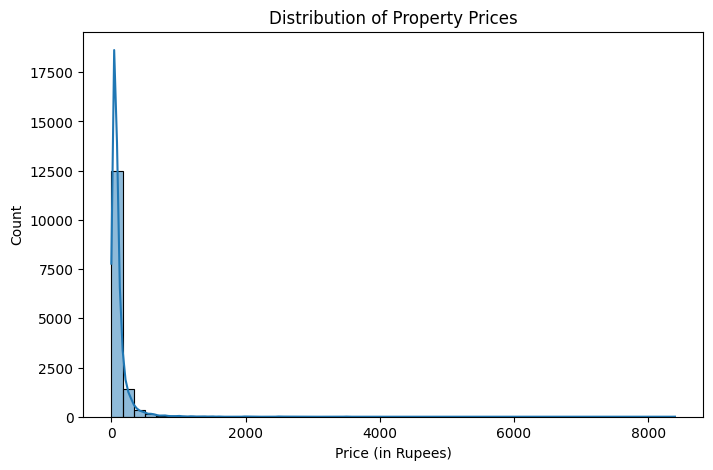

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
# Price distribution
plt.figure(figsize=(8,5))
sns.histplot(df["Price_Lakhs"], bins=50, kde=True)
plt.title("Distribution of Property Prices")
plt.xlabel("Price (in Rupees)")
plt.ylabel("Count")
plt.show()

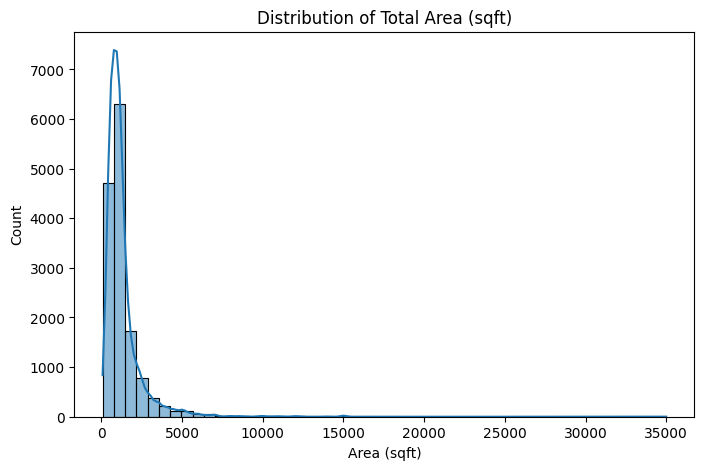

In [16]:
# Total Area distribution
plt.figure(figsize=(8,5))
sns.histplot(df["Total_Area"], bins=50, kde=True)
plt.title("Distribution of Total Area (sqft)")
plt.xlabel("Area (sqft)")
plt.ylabel("Count")
plt.show()

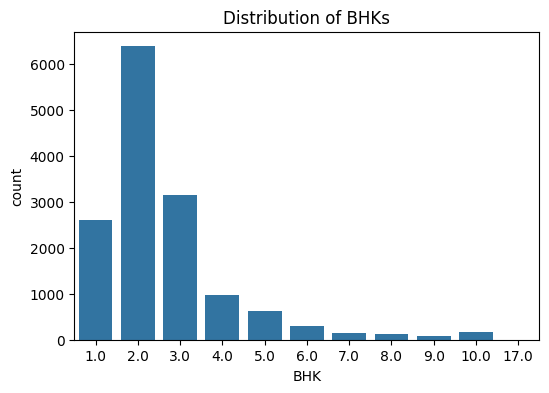

In [17]:
# BHK distribution
plt.figure(figsize=(6,4))
sns.countplot(x="BHK", data=df)
plt.title("Distribution of BHKs")
plt.show()

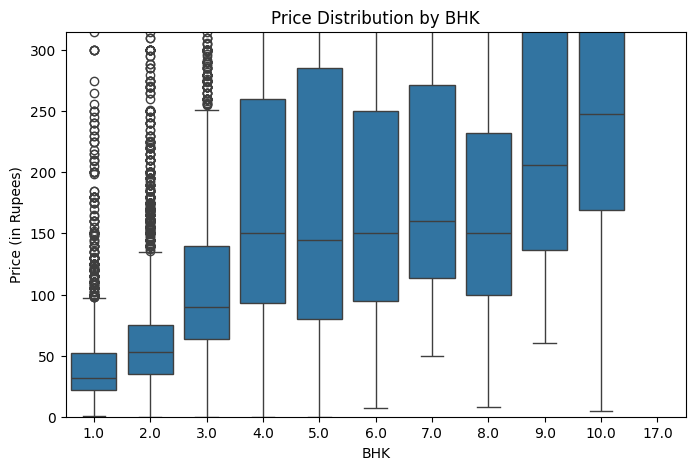

In [18]:
# Price vs BHK
plt.figure(figsize=(8,5))
sns.boxplot(x="BHK", y="Price_Lakhs", data=df)
plt.title("Price Distribution by BHK")
plt.xlabel("BHK")
plt.ylabel("Price (in Rupees)")
plt.ylim(0, df["Price_Lakhs"].quantile(0.95))  # remove extreme outliers
plt.show()

/tmp/ipython-input-988495468.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_locations.values, y=top_locations.index, palette="viridis")


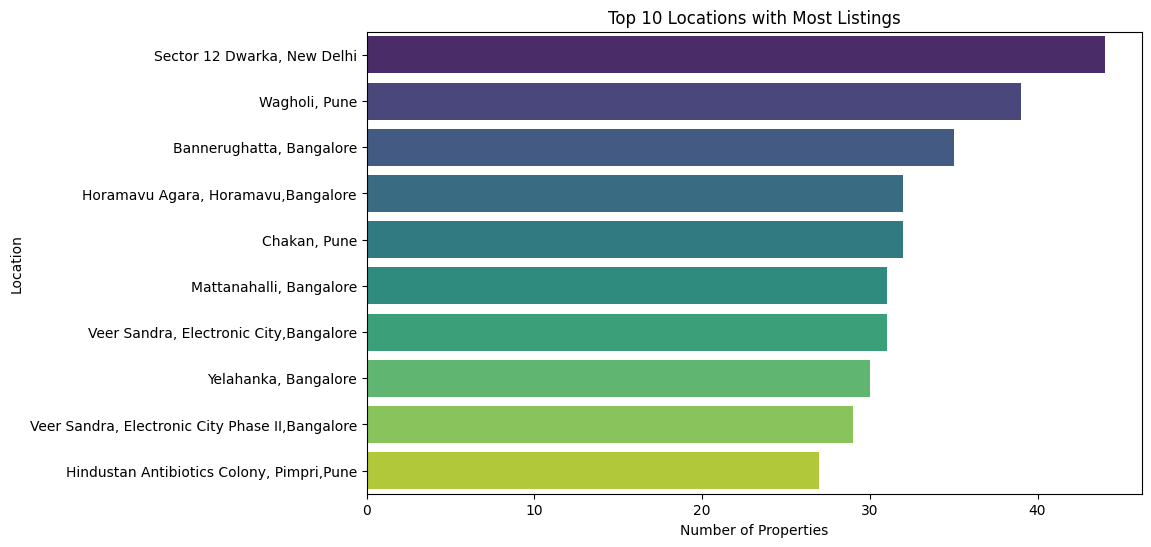

In [19]:
#Top 10 Locations with most properties
top_locations = df["Location"].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_locations.values, y=top_locations.index, palette="viridis")
plt.title("Top 10 Locations with Most Listings")
plt.xlabel("Number of Properties")
plt.ylabel("Location")
plt.show()

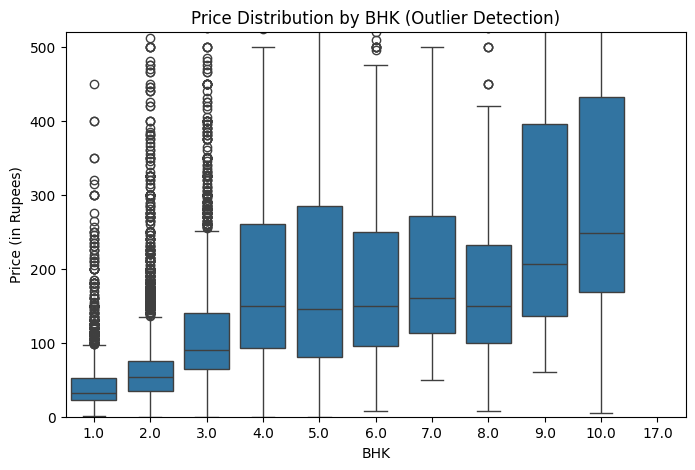

In [20]:
#Outlier Detection (Price vs Area)
plt.figure(figsize=(8,5))
sns.boxplot(x="BHK", y="Price_Lakhs", data=df)
plt.title("Price Distribution by BHK (Outlier Detection)")
plt.xlabel("BHK")
plt.ylabel("Price (in Rupees)")
plt.ylim(0, df["Price_Lakhs"].quantile(0.98))  # focus on majority
plt.show()

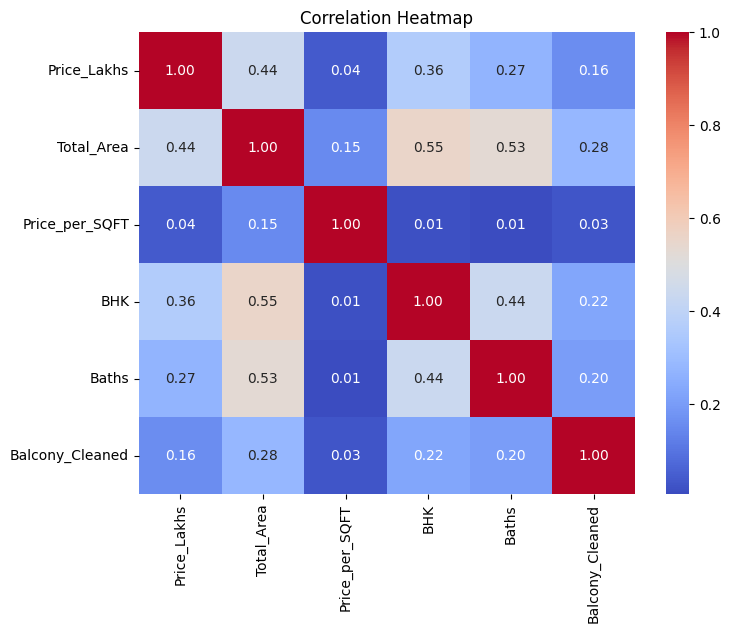

In [21]:
# Correlation Heatmap
plt.figure(figsize=(8,6))
#width 8 height 6
sns.heatmap(df[["Price_Lakhs", "Total_Area", "Price_per_SQFT", "BHK", "Baths", "Balcony_Cleaned"]].corr(),
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [22]:
# Features & Target
features = [
    "Total_Area",
    "Price_per_SQFT",
    "Baths",
    "Balcony_Cleaned",
    "BHK"
]
X = df[features].fillna(df[features].median())
y = df["Price_Lakhs"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predictions
y_pred = lin_reg.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("\n--- Model Performance Stage 1---")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")
#MAE: Average error (in lakhs or crores).
#RMSE: Penalizes larger errors more.
#R² Score: Goodness of fit (closer to 1 = better).


--- Model Performance Stage 1---
MAE: 57.22
RMSE: 118.60
R² Score: 0.2824


In [23]:
# Log Transform numerical features log(1+x)
# Many real estate features are skewed (few very large values).
# Log transformation reduces skewness and brings distributions closer to normal.
df["Total_Area_Log"] = np.log1p(df["Total_Area"])
df["Price_per_SQFT_Log"] = np.log1p(df["Price_per_SQFT"])

In [30]:
# Target Encoding (City, Locality)
# Each city/locality is replaced with the average price of properties there.
city_map = df.groupby("City")["Price_Lakhs"].mean().to_dict()
df["City_TargetEnc"] = df["City"].map(city_map)

locality_map = df.groupby("Locality")["Price_Lakhs"].mean().to_dict()
df["Locality_TargetEnc"] = df["Locality"].map(locality_map)

In [31]:
# Standard Scaling
# Prevents features with larger ranges (like area) from dominating smaller ones (like baths).
from sklearn.preprocessing import StandardScaler
num_cols = ["Total_Area_Log", "Price_per_SQFT_Log", "Baths", "BHK", "Balcony_Cleaned"]
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [32]:
df.head()

,Name,Property Title,Price,Location,Total_Area,Price_per_SQFT,Description,Baths,Balcony,Price_Lakhs,Balcony_Cleaned,BHK,Locality,City,Total_Area_Log,Price_per_SQFT_Log,City_TargetEnc,Locality_TargetEnc
0,Casagrand ECR 14,"4 BHK Flat for sale in Kanathur Reddikuppam, C...",₹1.99 Cr,"Kanathur Reddikuppam, Chennai",2583,7700.0,Best 4 BHK Apartment for modern-day lifestyle ...,1.390274,Yes,199.0,0.832610,0.873545,Kanathur Reddikuppam,Chennai,1.418390,0.168578,95.418075,122.666667
1,"Ramanathan Nagar, Pozhichalur,Chennai",10 BHK Independent House for sale in Pozhichal...,₹2.25 Cr,"Ramanathan Nagar, Pozhichalur,Chennai",7000,3210.0,Looking for a 10 BHK Independent House for sal...,3.616919,Yes,225.0,0.832610,4.638819,"Ramanathan Nagar, Pozhichalur",Chennai,2.938666,-1.068762,95.418075,193.500000
2,DAC Prapthi,"3 BHK Flat for sale in West Tambaram, Chennai",₹1.0 Cr,"Kasthuribai Nagar, West Tambaram,Chennai",1320,7580.0,"Property for sale in Tambaram, Chennai. This 3...",0.276951,No,100.0,-1.201042,0.245999,"Kasthuribai Nagar, West Tambaram",Chennai,0.395000,0.146364,95.418075,100.000000
3,"Naveenilaya,Chepauk, Triplicane,Chennai",7 BHK Independent House for sale in Triplicane...,₹3.33 Cr,"Naveenilaya,Chepauk, Triplicane,Chennai",4250,7840.0,Entire Building for sale with 7 units of singl...,2.503596,Yes,333.0,0.832610,2.756182,"Naveenilaya,Chepauk, Triplicane",Chennai,2.177702,0.194062,95.418075,333.000000
4,VGN Spring Field Phase 1,"2 BHK Flat for sale in Avadi, Chennai",₹48.0 L,"Avadi, Chennai",960,5000.0,"Property for sale in Avadi, Chennai. This 2 BH...",0.276951,Yes,48.0,0.832610,-0.381547,Avadi,Chennai,-0.090300,-0.442070,95.418075,52.780000


In [28]:
!pip install --upgrade category-encoders
import category_encoders as ce
def evaluate_linear(X, y, name, results):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results[name] = {
        "R2": r2_score(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred))
    }
    return results

#Binary Encoding
binary_enc = ce.BinaryEncoder(cols=["City", "Locality"])
df_bin = binary_enc.fit_transform(df[["City", "Locality"]])
X_bin = pd.concat([df[["Total_Area","Baths","Balcony_Cleaned","BHK"]], df_bin], axis=1)

#Target Encoding
target_enc = ce.TargetEncoder(cols=["City", "Locality"])
df_target = target_enc.fit_transform(df[["City", "Locality"]], df["Price_Lakhs"])
X_target = pd.concat([df[["Total_Area","Baths","Balcony_Cleaned","BHK"]], df_target], axis=1)

#hashing Encoding
hash_enc = ce.HashingEncoder(cols=["City", "Locality"], n_components=8)
df_hash = hash_enc.fit_transform(df[["City", "Locality"]])
X_hash = pd.concat([df[["Total_Area","Baths","Balcony_Cleaned","BHK"]], df_hash], axis=1)

#Results
y = df["Price_Lakhs"]
results = {}

results = evaluate_linear(X_bin, y, "Binary Encoding", results)
results = evaluate_linear(X_target, y, "Target Encoding", results)
results = evaluate_linear(X_hash, y, "Hashing Encoding", results)

# Show comparison
pd.DataFrame(results).T


,R2,MAE,RMSE
Binary Encoding,0.325164,55.528824,115.014324
Target Encoding,0.481818,47.900282,100.784561
Hashing Encoding,0.309622,55.729418,116.331278


In [33]:
#Features & Target
features = [
    "Total_Area_Log",
    "Price_per_SQFT_Log",
    "Baths",
    "Balcony_Cleaned",
    "BHK",
    "City_TargetEnc",
    "Locality_TargetEnc"
]
X = df[features].fillna(df[features].median())
y = df["Price_Lakhs"]

#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#Train Model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

#Evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("\n--- Model Performance before outlier handling ---")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")
#MAE: Average error (in lakhs or crores).
#RMSE: Penalizes larger errors more.
#R² Score: Goodness of fit (closer to 1 = better).


--- Model Performance before outlier handling ---
MAE: 40.33
RMSE: 93.86
R² Score: 0.5505


In [34]:
# Outlier Removal Function (IQR Method)
def remove_outliers_iqr(df, col, k=1.5):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - k * IQR
    upper = Q3 + k * IQR
    return df[(df[col] >= lower) & (df[col] <= upper)]

# Outlier Handling
df = remove_outliers_iqr(df, "Price_Lakhs", k=1.5)
df = remove_outliers_iqr(df, "Price_per_SQFT_Log", k=1.5)
df = remove_outliers_iqr(df, "Total_Area_Log", k=1.5)

# Features & Target
features = [
    "Total_Area_Log",
    "Price_per_SQFT_Log",
    "Baths",
    "Balcony_Cleaned",
    "BHK",
    "City_TargetEnc",
    "Locality_TargetEnc"
]
X = df[features].fillna(df[features].median())
y = df["Price_Lakhs"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predictions
y_pred = lin_reg.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("\n--- Model Performance after outlier handling---")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")
#MAE: Average error (in lakhs or crores).
#RMSE: Penalizes larger errors more.
#R² Score: Goodness of fit (closer to 1 = better).


--- Model Performance after outlier handling---
MAE: 11.51
RMSE: 15.35
R² Score: 0.8819


In [35]:
# Feature Engineering
# Price per BHK
df["Price_per_BHK"] = df["Price_Lakhs"] / (df["BHK"].replace(0, np.nan))

# Baths per BHK
df["Baths_per_BHK"] = df["Baths"] / (df["BHK"].replace(0, np.nan))

# Balcony ratio
df["Balcony_ratio"] = df["Balcony_Cleaned"] / (df["BHK"].replace(0, np.nan))

# Replace inf/nan created by division with 0
df.fillna(0, inplace=True)

# Features & Target
features = [
    "Total_Area_Log",
    "Price_per_SQFT_Log",
    "Baths",
    "Balcony_Cleaned",
    "BHK",
    "City_TargetEnc",
    "Locality_TargetEnc",
    "Price_per_BHK",
    "Baths_per_BHK",
    "Balcony_ratio"
]
X = df[features].fillna(df[features].median())
y = df["Price_Lakhs"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predictions
y_pred = lin_reg.predict(X_test)

# Evaluation
print("Linear Regression Performance (after Outlier Handling + Feature Engineering)")
print("----------------------------------------------------------------------------")
print("R2 Score :", r2_score(y_test, y_pred))
print("MAE      :", mean_absolute_error(y_test, y_pred))
print("RMSE     :", np.sqrt(mean_squared_error(y_test, y_pred)))

Linear Regression Performance (after Outlier Handling + Feature Engineering)
----------------------------------------------------------------------------
R2 Score : 0.8897175271545699
MAE      : 10.861966902391751
RMSE     : 14.830868016472492


In [37]:
#Comparing Training and Test Sets
# Predictions
y_train_pred = lin_reg.predict(X_train)
y_test_pred  = lin_reg.predict(X_test)

# Function for evaluation
def evaluate(y_true, y_pred, dataset_name):
    print(f"\n📊 {dataset_name} Set Performance")
    print("-"*40)
    print("R2 Score :", r2_score(y_true, y_pred))
    print("MAE      :", mean_absolute_error(y_true, y_pred))
    print("RMSE     :", np.sqrt(mean_squared_error(y_true, y_pred)))

# Compare Train vs Test
evaluate(y_train, y_train_pred, "Training")
evaluate(y_test, y_test_pred, "Test")



📊 Training Set Performance
----------------------------------------
R2 Score : 0.8827963224929511
MAE      : 11.27202235418888
RMSE     : 15.414448259375973

📊 Test Set Performance
----------------------------------------
R2 Score : 0.8897175271545699
MAE      : 10.861966902391751
RMSE     : 14.830868016472492
